<a href="https://colab.research.google.com/github/blackgreenc/AI/blob/main/index_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1317 차주형 - GSM 프로젝트(순환신경망 나스닥 지수 예측)

# 이 프로젝트는 순환신경망 중 LSTM과 GRU를 이용하여 나스닥을 예측하기 위한 모델입니다.


# 먼저 RNN에 대한 간략한 설명을 하겠습니다.
# RNN의 기본적 작동원리는 ht = g1 ( xtU + Wh(t-1) + bx), ot = g2 (Vh(t)+bh) 이다.
# g1 g2 : 비선형 활성화 함수 (Sigmoid, tanh 등)
# xt: 입력값
# ht: t(시간)단계의 은닉변수 (hidden state)
# ot: t(시간)단계의 출력값
# b: 편향 (bias)
# U, V, W: xt, ht, ht-1의 가중치 (weight)
# 위 식에서 입력 X = (x1 , x2 , x3 , ... , xn)이 입력되면 ot가 출력됩니다.


# LSTM은 1997년 나온 RNN의 개선판으로. 학습이 오래 지속될 경우 초기 학습한 내용이 잊혀진다는 단점이 있는데 이를 개선한 architecture입니다. 
# RNN의 입력, forget, 출력 부분에 Gate라는 셀들을 붙여 값을 조절합니다. Forget gate는 이전 상태 정보를 저장할지를 결정하고, 
# input gate는 입력되는 새로운 정보를 저장할지 결정하고, output gate는 갱신된 cell의 출력값을 제어합니다.

# GRU는 LSTM을 더 가볍게 돌리기 위해 단순히 만든 것 입니다


In [2]:
!pip install yfinance
import numpy as np
import tensorflow as tf
import pandas as pd
import yfinance as yf #야후 파이낸스 데이터

     |████████████████████████████████| 6.3 MB 29.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=e7a259b16ac8eb81673d6180176842f055e4afaac84a2405ce9f0559a724001e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
# 예측할 값은 나스닥지수로 이를 위해 학습할 데이터는 나스닥100지수, S&P500지수, 유가 정보입니다.
# 학습할 데이터는 2007년부터 2021년 전까지의 데이터, 예측할 테스트 데이터는 2021년 이후의 데이터입니다

There are251observations in the training data
There are3715observations in the training data


,NDX_Adj Close,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume
Date,,,,,,
2007-01-03,1759.37,1769.22,1793.05,1731.71,1759.37,2435280000
2007-01-04,1792.91,1763.15,1799.07,1757.00,1792.91,2104210000
2007-01-05,1785.30,1787.79,1787.79,1770.29,1785.30,2060360000
2007-01-08,1787.14,1786.39,1795.45,1776.99,1787.14,1905620000
2007-01-09,1795.63,1791.75,1802.44,1776.73,1795.63,2144160000
2007-01-10,1816.15,1790.51,1817.22,1784.28,1816.15,2274210000
2007-01-11,1834.86,1820.75,1840.88,1818.09,1834.86,2436270000
2007-01-12,1844.81,1832.15,1845.68,1830.34,1844.81,2175810000
2007-01-16,1842.44,1844.73,1847.54,1836.83,1842.44,2139550000


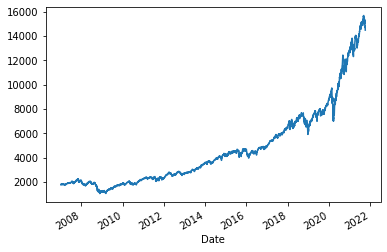

In [4]:
# 나스닥 100
NDX  = yf.download('NDX',
                     start = '2007-01-01',
                     end = '2021-10-5',
                     progress = False)

NDX_data = NDX[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
NDX_data.rename(columns={'Adj Close':'NDX_Adj Close', 'Open':'NDX_Open', 'High':'NDX_High', 'Low':'NDX_Low', 'Close':'NDX_Close', 'Volume':'NDX_Volume' }, inplace=True)


print("There are" + str(NDX_data[:"2007"].shape[0]) + "observations in the training data")
print("There are" + str(NDX_data[:"2021"].shape[0]) + "observations in the training data")

NDX_data['NDX_Adj Close'].plot()
NDX_data.shape
NDX_data.head(10)

There are251observations in the training data
There are3715observations in the training data


,ES_Adj Close,ES_Open,ES_High,ES_Low,ES_Close,ES_Volume
Date,,,,,,
2007-01-03,17.57,27.95,28.47,27.91,28.43,1418800
2007-01-04,17.43,28.40,28.46,28.16,28.20,757100
2007-01-05,17.07,28.12,28.17,27.43,27.61,720600
2007-01-08,17.16,27.54,27.82,27.49,27.76,606200
2007-01-09,17.15,27.73,27.81,27.44,27.74,555600
2007-01-10,17.13,27.72,27.87,27.50,27.71,840300
2007-01-11,17.13,27.77,27.90,27.67,27.72,595600
2007-01-12,17.11,27.75,27.87,27.55,27.69,500500
2007-01-16,17.10,27.61,27.98,27.58,27.67,663900


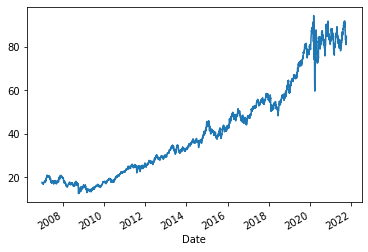

In [5]:

# s&p 500
ES  = yf.download('ES',
                     start = '2007-01-01',
                     end = '2021-10-5',
                     progress = False)

ES_data = ES[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
ES_data.rename(columns={'Adj Close':'ES_Adj Close', 'Open':'ES_Open', 'High':'ES_High', 'Low':'ES_Low', 'Close':'ES_Close', 'Volume':'ES_Volume' }, inplace=True)


print("There are" + str(ES_data[:"2007"].shape[0]) + "observations in the training data")
print("There are" + str(ES_data[:"2021"].shape[0]) + "observations in the training data")

ES_data['ES_Adj Close'].plot()
ES_data.shape
ES_data.head(10)

There are251observations in the training data
There are3715observations in the training data


,WTI_Adj Close,WTI_Open,WTI_High,WTI_Low,WTI_Close,WTI_Volume
Date,,,,,,
2007-01-03,22.62,30.60,30.60,29.65,29.82,758700
2007-01-04,22.22,29.81,29.81,28.99,29.29,495000
2007-01-05,22.57,29.10,29.85,29.04,29.75,511400
2007-01-08,22.38,30.00,30.30,29.10,29.50,478400
2007-01-09,22.42,29.28,29.87,28.74,29.55,559600
2007-01-10,21.57,28.80,28.95,28.08,28.41,656300
2007-01-11,21.00,28.37,28.74,27.50,27.65,565400
2007-01-12,21.79,27.71,28.77,27.71,28.70,431700
2007-01-16,21.47,28.50,28.89,28.04,28.28,380200


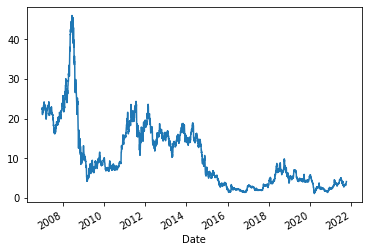

In [6]:
# 기름 
WTI  = yf.download('WTI',
                     start = '2007-01-01',
                     end = '2021-10-05',
                     progress = False)

WTI_data = WTI[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
WTI_data.rename(columns={'Adj Close':'WTI_Adj Close', 'Open':'WTI_Open', 'High':'WTI_High', 'Low':'WTI_Low', 'Close':'WTI_Close', 'Volume':'WTI_Volume' }, inplace=True)


print("There are" + str(WTI_data[:"2007"].shape[0]) + "observations in the training data")
print("There are" + str(WTI_data[:"2021"].shape[0]) + "observations in the training data")

WTI_data['WTI_Adj Close'].plot()
WTI_data.head(10)

In [7]:
# 각각의 데이터들을 결합하여 학습데이터로 만들기 위해 합치는 과정입니다.
all_data = pd.concat([ NDX_data, WTI_data['WTI_Adj Close'], ES_data['ES_Adj Close']], axis=1)
all_data.head(12)

,NDX_Adj Close,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume,WTI_Adj Close,ES_Adj Close
Date,,,,,,,,
2007-01-03,1759.37,1769.22,1793.05,1731.71,1759.37,2435280000,22.62,17.57
2007-01-04,1792.91,1763.15,1799.07,1757.00,1792.91,2104210000,22.22,17.43
2007-01-05,1785.30,1787.79,1787.79,1770.29,1785.30,2060360000,22.57,17.07
2007-01-08,1787.14,1786.39,1795.45,1776.99,1787.14,1905620000,22.38,17.16
2007-01-09,1795.63,1791.75,1802.44,1776.73,1795.63,2144160000,22.42,17.15
2007-01-10,1816.15,1790.51,1817.22,1784.28,1816.15,2274210000,21.57,17.13
2007-01-11,1834.86,1820.75,1840.88,1818.09,1834.86,2436270000,21.00,17.13
2007-01-12,1844.81,1832.15,1845.68,1830.34,1844.81,2175810000,21.79,17.11
2007-01-16,1842.44,1844.73,1847.54,1836.83,1842.44,2139550000,21.47,17.10


입력값과 출력값 데이터를 위한 코드

In [8]:
# e데이터 정규화를 위한 함수

def ts_train_test_normalize(all_data, time_steps, for_periods):
   
    # create training and test set 
    ts_train = all_data[:'2021'].iloc[:,0:1].values
    ts_test = all_data['2021':].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((all_data["NDX_Adj Close"][:'2021'], all_data["NDX_Adj Close"]['2021':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc

In [9]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5, 2)

X_train.shape[0], X_train.shape[1]

(3709, 5)

In [10]:
# 3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# 3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
# There are ? samples in the training data

print("There are " + str(X_test.shape[0]) + " samples in the test data")
# There are ? samples in the test data

There are 3709 samples in the training data
There are 188 samples in the test data


In [79]:
# LSTM모델 정의
def LSTM_model(X_train, y_train, X_test, sc):
    # import neccesary modul
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD

    # LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50,
                           return_sequences = True,
                           input_shape = (X_train.shape[1],1),
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units = 2))

    # compiling
    my_LSTM_model.compile(optimizer =SGD(lr = 0.17, decay = 1e-7, momentum = 0.98, nesterov = False),
                          loss = 'mean_squared_error') # momentum은 관성을 나타냄
    
    # training data 세트에 피팅하기 (조기 중단은 추가함)
    my_LSTM_model.fit(X_train, y_train, epochs = 18, batch_size = 150, verbose = 0)

    # X_test를 LSTM model에 넣어서 예측하기
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [80]:
def actual_pred_plot(preds):

    actual_pred = pd.DataFrame(columns = ['NDX_Adj Close', 'prediction'])
    actual_pred['NDX_Adj Close'] = all_data.loc['2021':, 'NDX_Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:, 0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['NDX_Adj Close']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(78111.945, <matplotlib.axes._subplots.AxesSubplot at 0x7fc20980e8d0>)

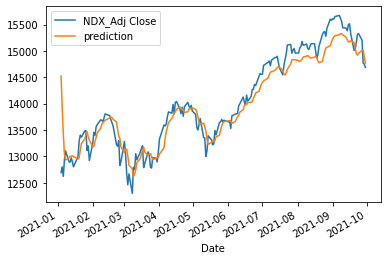

In [81]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [82]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test = all_data.loc['2021':, 'NDX_Adj Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop = True, inplace = True)

In [77]:
# 예측성능 출력지표들 
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    # 실제 값과 예측 값의 차이를 절댓값으로 변환해 평균한 것

    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    # MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 RMSE 값을 쓰는 것입니다.
    
    MSLE = mean_squared_log_error(y_test, y_pred)
    # MSE에 로그를 적용해준 지표입니다. log(y)가 아니라 log(y+1)입니다. y=0일 때, log(y)는 마이너스 무한대이므로 이를 보정해주기 위해 +1을 한 것입니다. 

    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    # RMSE에 로그를 적용해준 지표입니다.

    R2 = r2_score(y_test, y_pred)
    # R² 는 분산 기반으로 예측 성능을 평가합니다. 1에 가까울수록 예측 정확도가 높습니다.
    # R² = 예측값 Variance / 실제값 Variance
    
    Result = pd.DataFrame(data = [MAE, RMSE, RMSLE, R2],
                          index = ['MAE', 'RMSE', 'RMSLE', 'R2'],
                          columns = ['Results'])
    
    return Result

In [83]:
# result check
confirm_result(y_test, y_pred)

,Results
MAE,205.369645
RMSE,279.485128
RMSLE,0.020174
R2,0.901306


In [56]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.17, decay = 1e-7, 
                                         momentum = 0.98, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 18, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(46010.83, <matplotlib.axes._subplots.AxesSubplot at 0x7fc208c9a390>)

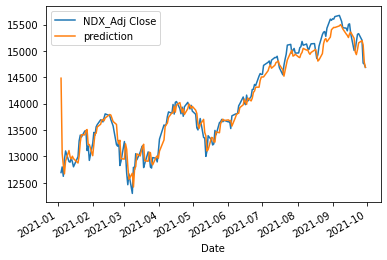

In [57]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [58]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=NDX_data.loc['2021':,'NDX_Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [59]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,144.443885
RMSE,214.501341
RMSLE,0.015690
R2,0.941866


In [84]:
# LSTM은 90.1304%, GRU는 94.1866%의 정확도를 보여주는 것으로 보아서 이 데이터에서는 GRU가 더 유리하다는 것을 알 수 있습니다.